<a href="https://colab.research.google.com/github/Jaderfonseca/lime-smile-classifier/blob/main/neural_network_with_LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# === Synthetic "smiley vs not_smile" dataset (clean mouth logic) ===
# Creates data/raw/{smile,not_smile}/*.png and data/raw/labels.csv

import os, csv, random, math
from pathlib import Path
import numpy as np
from PIL import Image, ImageDraw, ImageFilter

# ---- Config (tweak freely) ----
RANDOM_SEED    = 123
IMG_SIZE       = 48          # larger than 32 to reduce blockiness
N_PER_CLASS    = 500
OUT_DIR        = Path("data/raw")
CLASSES        = ["smile", "not_smile"]

STROKE         = 2           # line width for face/eyes/mouth
ADD_NOISE_P    = 0.12        # prob. of adding blur+noise (lower for cleaner icons)
NOISE_SIGMAS   = [0, 2, 3]   # std-dev options for Gaussian noise
BLUR_RADIUS    = 0.35

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

(OUT_DIR / "smile").mkdir(parents=True, exist_ok=True)
(OUT_DIR / "not_smile").mkdir(parents=True, exist_ok=True)

def _clip(lo, hi, x):
    return max(lo, min(hi, x))

def add_noise(img, sigma):
    if sigma <= 0:
        return img
    arr   = np.array(img, dtype=np.int16)
    noise = np.random.normal(0, sigma, arr.shape)
    arr   = np.clip(arr + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(arr, mode="L")

def draw_mouth_curve(drw, x0, y0, x2, y2, cy, width, fg=0):
    """
    Quadratic Bezier from (x0,y0) to (x2,y2) with control ( (x0+x2)/2 , cy ).
    width = stroke width.
    """
    import numpy as np
    xs, ys = [], []
    cx = (x0 + x2) / 2.0
    for t in np.linspace(0, 1, 50):
        # Quadratic Bezier: B(t) = (1-t)^2 P0 + 2(1-t)t C + t^2 P2
        bx = (1-t)**2 * x0 + 2*(1-t)*t * cx + t**2 * x2
        by = (1-t)**2 * y0 + 2*(1-t)*t * cy + t**2 * y2
        xs.append(bx); ys.append(by)
    pts = list(map(tuple, np.stack([xs, ys], axis=1).astype(int)))
    drw.line(pts, fill=fg, width=width)

def draw_face(label="smile"):
    """Return a 48x48 grayscale face with a clear smile or not_smile."""
    W = H = IMG_SIZE
    bg, fg = 255, 0

    # Canvas
    img = Image.new("L", (W, H), color=bg)
    drw = ImageDraw.Draw(img)

    # Face (circle)
    r  = random.randint(int(W*0.35), int(W*0.44))
    cx = random.randint(int(W*0.48), int(W*0.52))
    cy = random.randint(int(H*0.48), int(H*0.52))
    bbox = [cx-r, cy-r, cx+r, cy+r]
    drw.ellipse(bbox, outline=fg, width=STROKE)

    # Eyes
    eye_r  = random.randint(3, 4)
    eye_dx = random.randint(6, 8)
    eye_y  = cy - random.randint(int(H*0.10), int(H*0.14))

    left_eye  = (cx - eye_dx - eye_r, eye_y - eye_r, cx - eye_dx + eye_r, eye_y + eye_r)
    right_eye = (cx + eye_dx - eye_r, eye_y - eye_r, cx + eye_dx + eye_r, eye_y + eye_r)
    drw.ellipse(left_eye,  fill=fg)
    drw.ellipse(right_eye, fill=fg)

    # Mouth baseline
    mouth_w = random.randint(int(W*0.50), int(W*0.66))
    mouth_y = random.randint(int(H*0.62), int(H*0.68))
    x0 = cx - mouth_w//2
    x2 = cx + mouth_w//2
    y0 = y2 = mouth_y

    # Curvature: positive -> control BELOW baseline (looks like a smile in image coords),
    # negative -> control ABOVE baseline (frown). 0 -> flat.
    base_curve = random.randint(6, 9)  # curvature magnitude in pixels (increase for more obvious)
    if label == "smile":
        cy_ctrl = mouth_y + base_curve + random.randint(0, 2)  # below baseline => U shape
        draw_mouth_curve(drw, x0, y0, x2, y2, cy_ctrl, width=STROKE, fg=fg)
    else:
        mode = random.choice(["frown", "flat"])
        if mode == "flat":
            drw.line([(x0, mouth_y), (x2, mouth_y)], fill=fg, width=STROKE)
        else:
            cy_ctrl = mouth_y - base_curve - random.randint(0, 2)  # above baseline => ∩
            draw_mouth_curve(drw, x0, y0, x2, y2, cy_ctrl, width=STROKE, fg=fg)

    # Mild blur + optional noise (kept small so shapes stay recognizable)
    if random.random() < ADD_NOISE_P:
        img = img.filter(ImageFilter.GaussianBlur(radius=BLUR_RADIUS))
        sigma = random.choice(NOISE_SIGMAS)
        img = add_noise(img, sigma=sigma)

    return img

# ---- Generate and save ----
rows = []
for label in CLASSES:
    for i in range(N_PER_CLASS):
        img   = draw_face(label=label)
        fname = f"{label}_{i:04d}.png"
        fpath = OUT_DIR / label / fname
        img.save(fpath)
        rows.append({"filepath": str(fpath.as_posix()), "label": label})

labels_csv = OUT_DIR / "labels.csv"
with open(labels_csv, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=["filepath","label"])
    w.writeheader(); w.writerows(rows)

print(f"OK! Generated: {len(rows)} images")
print(f" - {sum(r['label']=='smile' for r in rows)} smiles")
print(f" - {sum(r['label']=='not_smile' for r in rows)} not_smile")
print(f"CSV: {labels_csv}")


/tmp/ipython-input-4290181546.py:36: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, mode="L")


OK! Generated: 1000 images
 - 500 smiles
 - 500 not_smile
CSV: data/raw/labels.csv


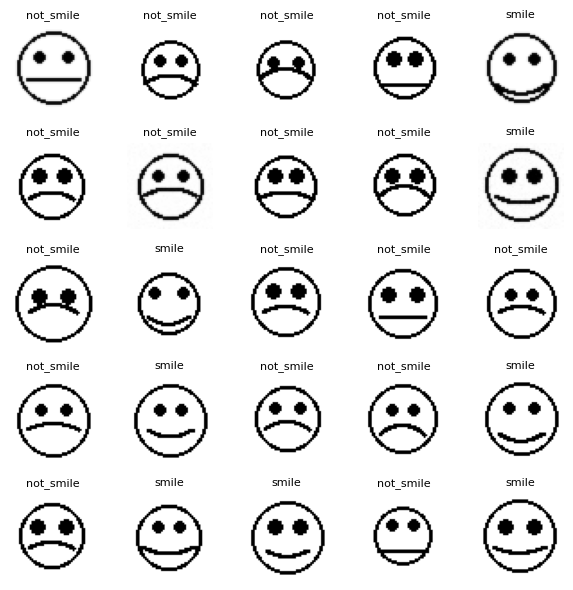

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

df = pd.read_csv("data/raw/labels.csv")
sample = df.sample(25, random_state=42).reset_index(drop=True)

plt.figure(figsize=(6,6))
for i,(fp,lab) in enumerate(zip(sample["filepath"], sample["label"])):
    ax = plt.subplot(5,5,i+1)
    ax.imshow(Image.open(fp), cmap="gray")
    ax.set_title(lab, fontsize=8)
    ax.axis("off")
plt.tight_layout(); plt.show()


In [4]:
# --- Preprocess: images -> flat numeric vectors ---

import json, csv, os
from pathlib import Path
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

RAW_DIR       = Path("data/raw")
PROC_DIR      = Path("data/processed")
LABELS_CSV    = RAW_DIR / "labels.csv"
IMG_SIZE      = 48          # must match generation (or detect from first img)
BINARIZE      = False       # set True to force 0/1 pixels
THRESHOLD     = 128         # used if BINARIZE=True
NORMALIZE     = True        # divide by 255 to [0,1]
RANDOM_SEED   = 42

PROC_DIR.mkdir(parents=True, exist_ok=True)

# 1) load table
rows = []
with open(LABELS_CSV, "r") as f:
    for r in csv.DictReader(f):
        rows.append(r)

print(f"Loaded {len(rows)} filepaths from {LABELS_CSV}")

# 2) encode labels
label_to_id = {"smile": 1, "not_smile": 0}
id_to_label = {v:k for k,v in label_to_id.items()}

# 3) loader + featurizer
def load_as_vector(path):
    img = Image.open(path).convert("L")
    if img.size != (IMG_SIZE, IMG_SIZE):
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.NEAREST)

    arr = np.array(img, dtype=np.uint8)

    if BINARIZE:
        arr = (arr >= THRESHOLD).astype(np.uint8) * 255

    if NORMALIZE:
        arr = arr.astype(np.float32) / 255.0
    else:
        arr = arr.astype(np.float32)

    return arr.flatten()  # shape: (IMG_SIZE*IMG_SIZE,)


Loaded 1000 filepaths from data/raw/labels.csv


In [5]:
# build feature matrix
X_list, y_list = [], []

for r in rows:
    fp = r["filepath"]
    y_list.append(label_to_id[r["label"]])
    X_list.append(load_as_vector(fp))

X = np.vstack(X_list)               # (N, IMG_SIZE*IMG_SIZE)
y = np.array(y_list, dtype=np.int64)

print("Feature matrix:", X.shape, "labels:", y.shape)
print("Class balance: smiles=", (y==1).sum(), " | not_smile=", (y==0).sum())

# stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

# save arrays
np.save(PROC_DIR / "X_train.npy", X_train)
np.save(PROC_DIR / "X_test.npy",  X_test)
np.save(PROC_DIR / "y_train.npy", y_train)
np.save(PROC_DIR / "y_test.npy",  y_test)

# save a tiny metadata companion for reproducibility
meta = {
    "img_size": IMG_SIZE,
    "binarize": BINARIZE,
    "threshold": THRESHOLD,
    "normalize": NORMALIZE,
    "random_seed": RANDOM_SEED,
    "n_total": int(X.shape[0]),
    "n_train": int(X_train.shape[0]),
    "n_test": int(X_test.shape[0]),
    "n_features": int(X.shape[1]),
    "label_to_id": label_to_id,
}
with open(PROC_DIR / "preprocess_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print("Saved to:", PROC_DIR)
for p in ["X_train.npy","X_test.npy","y_train.npy","y_test.npy","preprocess_meta.json"]:
    print(" -", PROC_DIR / p)


Feature matrix: (1000, 2304) labels: (1000,)
Class balance: smiles= 500  | not_smile= 500
Saved to: data/processed
 - data/processed/X_train.npy
 - data/processed/X_test.npy
 - data/processed/y_train.npy
 - data/processed/y_test.npy
 - data/processed/preprocess_meta.json


In [ ]:
# quick checks
Xt = np.load(PROC_DIR / "X_train.npy")
yt = np.load(PROC_DIR / "y_train.npy")

print("Shapes -> X_train:", Xt.shape, "| y_train:", yt.shape)
print("Means/std (first 5 cols):", Xt[:, :5].mean(axis=0), Xt[:, :5].std(axis=0))
print("Train balance:", (yt==1).sum(), "(smile) |", (yt==0).sum(), "(not_smile)")


Shapes -> X_train: (800, 2304) | y_train: (800,)
Means/std (first 5 cols): [0.999691   0.99957335 0.9995537  0.99961257 0.9994752 ] [0.00187066 0.00219021 0.00238802 0.00226637 0.00268378]
Train balance: 400 (smile) | 400 (not_smile)


Shapes: (800, 2304) (200, 2304) (800,) (200,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,361 (1.16 MB)

 Trainable params: 303,361 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5714 - loss: 0.8634 - val_accuracy: 0.5063 - val_loss: 0.6406
Epoch 2/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6195 - loss: 0.6551 - val_accuracy: 0.8813 - val_loss: 0.5167
Epoch 3/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7707 - loss: 0.5285 - val_accuracy: 0.8438 - val_loss: 0.4315
Epoch 4/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8464 - loss: 0.4129 - val_accuracy: 0.8875 - val_loss: 0.2818
Epoch 5/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8963 - loss: 0.2961 - val_accuracy: 0.8938 - val_loss: 0.2611
Epoch 6/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9074 - loss: 0.2475 - val_accuracy: 0.8938 - val_loss: 0.1958
Epoch 7/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9236 - loss: 0.1891 - val_accuracy: 0.9312 - val_loss: 0.1665
Epoch 8/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9329 - loss: 0.1857 - val_accuracy: 0.9500 - v

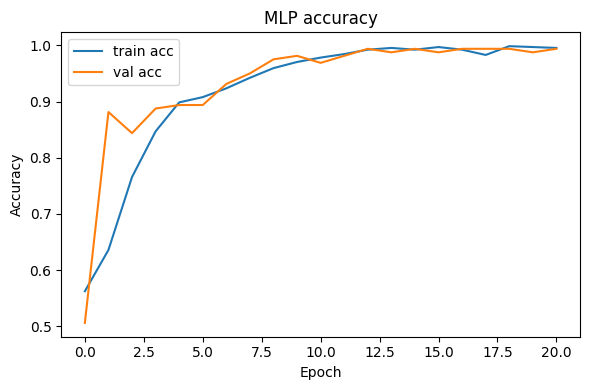

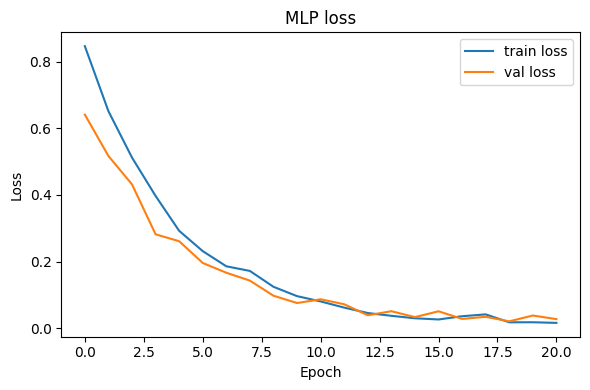

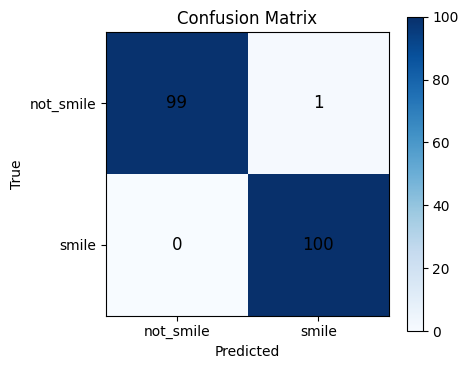

In [6]:
# --- Tiny MLP for smile vs not_smile (Keras/TF) ---

import os, json, random, numpy as np
import tensorflow as tf
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

PROC_DIR = Path("data/processed")
MODEL_DIR = Path("models"); MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = Path("figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load processed data
X_train = np.load(PROC_DIR / "X_train.npy")   # shape: (N, D)
X_test  = np.load(PROC_DIR / "X_test.npy")
y_train = np.load(PROC_DIR / "y_train.npy")   # shape: (N,)
y_test  = np.load(PROC_DIR / "y_test.npy")

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Scale inputs to [0,1] if not already
if X_train.max() > 1.0:
    X_train = X_train / 255.0
    X_test  = X_test  / 255.0

input_dim = X_train.shape[1]

# Build a small MLP (2 hidden layers)
from tensorflow.keras import layers, models, callbacks, optimizers

def make_model(input_dim: int) -> tf.keras.Model:
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dropout(0.15)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.10)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = make_model(input_dim)
model.summary()

# Callbacks: early stopping + best model checkpoint
ckpt_path = str(MODEL_DIR / "mlp_smile_best.keras")
cbs = [
    callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_accuracy"),
    callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True)
]

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=60,
    batch_size=64,
    callbacks=cbs,
    verbose=1
)

# Save final model and training history
model.save(MODEL_DIR / "mlp_smile_final.keras")
with open(MODEL_DIR / "mlp_smile_history.json", "w") as f:
    json.dump({k: [float(v) for v in vals] for k, vals in history.history.items()}, f)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.3f}  |  Test loss: {test_loss:.4f}")

# Predictions & reports
y_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("\nClassification report:\n",
      classification_report(y_test, y_pred, target_names=["not_smile","smile"]))

cm = confusion_matrix(y_test, y_pred)

# Plot: training curves
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("MLP accuracy")
plt.legend(); plt.tight_layout()
plt.savefig(FIG_DIR / "mlp_accuracy.png", dpi=160)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("MLP loss")
plt.legend(); plt.tight_layout()
plt.savefig(FIG_DIR / "mlp_loss.png", dpi=160)
plt.show()

# Plot: confusion matrix
plt.figure(figsize=(4.8,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
tick = np.arange(2)
plt.xticks(tick, ["not_smile","smile"])
plt.yticks(tick, ["not_smile","smile"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.savefig(FIG_DIR / "mlp_confusion_matrix.png", dpi=160)
plt.show()


In [9]:
model.save("models/mlp_smile_classifier.keras")


In [10]:
import os

os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

# salvar modelo e histórico
model.save("models/mlp_smile_classifier.keras")
np.save("results/history.npy", history.history)
